In [1]:
import numpy as np
import scipy.io
import pandas as pd

import pymc as pm
import aesara.tensor as aet
import arviz as az

In [18]:
pm.__version__

'4.0.0b1'

In [2]:
import matplotlib.pyplot as plt

Load basin information

In [3]:
dem = scipy.io.loadmat('Shillong_DEM.mat')   
Z = dem['Z']/1000 # convert meters to kilometers for consistency with RVs

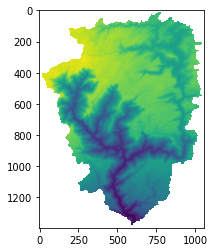

In [4]:
plt.imshow(Z);

Load thermochronology datathermo_file

In [5]:
thermo_file = pd.read_csv('Avdeev_detrital.txt', sep='\t')
thermo_file = thermo_file.rename(
    columns={thermo_file.columns[i-1]:thermo_file.columns[i] 
             for i in range(1, len(thermo_file.columns))}
).iloc[:, :-1]
thermo_file

,Age(Ma),E (Ma),U (ppm),Th (ppm),4He (nmol/g),Mass (g),Ft,Radius (m),Sm (ppm)
0,8.34,0.38,3.22,12.37,0.22,3.90,0.75,61.62,292.94
1,5.60,0.17,29.96,117.58,1.27,2.91,0.72,56.32,333.33
2,35.80,1.41,0.70,3.10,0.21,19.49,0.74,60.95,8.77
3,6.93,0.17,30.69,88.97,1.58,5.95,0.81,87.46,231.81
4,4.96,0.15,7.83,12.27,0.22,18.41,0.75,53.01,116.32
5,7.87,0.28,6.47,8.93,0.31,5.50,0.80,81.37,273.40
6,15.93,0.57,2.27,6.07,0.23,16.40,0.70,51.46,23.03
7,9.55,0.39,6.47,8.93,0.31,5.50,0.65,41.30,273.40
8,7.47,0.23,47.87,62.88,1.89,2.10,0.74,62.50,342.97
9,11.95,0.40,25.22,10.00,1.28,3.22,0.71,43.95,193.17


In [6]:
thermo_age = thermo_file['Age(Ma)'].values

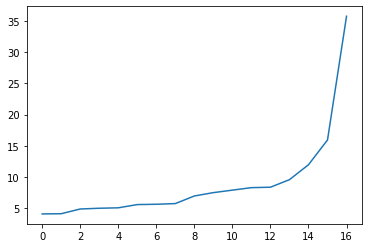

In [7]:
plt.plot(np.sort(thermo_age));

/opt/miniconda3/envs/aesara-dev/lib/python3.9/site-packages/aesara/tensor/elemwise.py:767: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


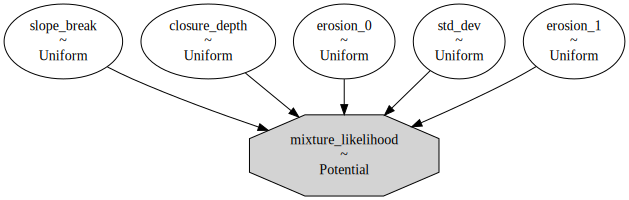

In [8]:
Z_exclude_nan = Z[np.isfinite(Z)]

with pm.Model(check_bounds=False) as detrital_thermo_org:
    slope_break = pm.Uniform('slope_break', lower=0, upper=60)
    erosion_0 = pm.Uniform('erosion_0', lower=0.01, upper=1)
    erosion_1 = pm.Uniform('erosion_1', lower=0.01, upper=1)
    closure_depth = pm.Uniform('closure_depth', lower=-1, upper=4)
    std_dev = pm.Uniform('std_dev', lower=0.05, upper=0.5)
    #alpha = Uniform('alpha', lower=0, upper=1) # isotherm topo-deflection coeff
    closure_depth_1 = closure_depth + slope_break * (erosion_0 - erosion_1)
    
    # Bedrock cooling age
    # changed minus to plus sign in age calculation; error in Avdeev's?
    b_0 = ((Z_exclude_nan + closure_depth) / erosion_0)
    b_1 = ((Z_exclude_nan + closure_depth_1) / erosion_1)
    age = aet.switch((b_0 < slope_break), b_0, b_1) 
    sigma_age = age * std_dev
    
    weight = np.ones_like(Z_exclude_nan)
    weight = weight / weight.sum()
    # p_D = pm.NormalMixture('p_D', w=weight, mu=age, sigma=sigma_age, 
    #                        observed=thermo_age)
    # In pymc v3
    # comp_loglike = pm.Normal.dist(age, sigma_age).logp(thermo_age[..., None])
    comp_loglike = pm.logp(pm.Normal.dist(age, sigma_age), thermo_age[..., None])
    mixture_likelihood = pm.Potential(
        'mixture_likelihood', 
        aet.sum(pm.math.logsumexp(comp_loglike+aet.log(weight[None, ...]), axis=-1)))

pm.model_to_graphviz(detrital_thermo_org)

In [9]:
detrital_thermo_org.point_logps()

slope_break            -1.39
erosion_0              -1.39
erosion_1              -1.39
closure_depth          -1.39
std_dev                -1.39
mixture_likelihood   -188.91
Name: Point log-probability, dtype: float64

In [10]:
Z_unique, Z_count = np.unique(Z_exclude_nan, return_counts=True)
Z_exclude_nan.shape, Z_count.shape

((945994,), (1910,))

/opt/miniconda3/envs/aesara-dev/lib/python3.9/site-packages/aesara/tensor/elemwise.py:767: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


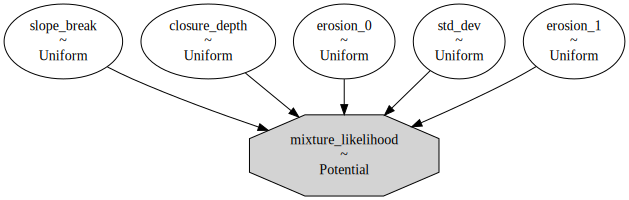

In [11]:
with pm.Model(check_bounds=False) as detrital_thermo:
    slope_break = pm.Uniform('slope_break', lower=0, upper=60)
    erosion_0 = pm.Uniform('erosion_0', lower=0.01, upper=1)
    erosion_1 = pm.Uniform('erosion_1', lower=0.01, upper=1)
    closure_depth = pm.Uniform('closure_depth', lower=-1, upper=4)
    std_dev = pm.Uniform('std_dev', lower=0.05, upper=0.5)
    #alpha = Uniform('alpha', lower=0, upper=1) # isotherm topo-deflection coeff
    closure_depth_1 = closure_depth + slope_break * (erosion_0 - erosion_1)
    
    # Bedrock cooling age
    # changed minus to plus sign in age calculation; error in Avdeev's?
    b_0 = ((Z_unique + closure_depth) / erosion_0)
    b_1 = ((Z_unique + closure_depth_1) / erosion_1)
    age = aet.switch((b_0 < slope_break), b_0, b_1) 
    sigma_age = age * std_dev
    
    weight = Z_count.astype(np.float64)
    weight = weight / weight.sum()
    # p_D = pm.NormalMixture('p_D', w=weight, mu=age, sigma=sigma_age, 
    #                        observed=thermo_age)
    # In pymc v3
    # comp_loglike = pm.Normal.dist(age, sigma_age).logp(thermo_age[..., None])
    comp_loglike = pm.logp(pm.Normal.dist(age, sigma_age), thermo_age[..., None])
    mixture_likelihood = pm.Potential(
        'mixture_likelihood', 
        aet.sum(pm.math.logsumexp(comp_loglike+aet.log(weight[None, ...]), axis=-1)))

pm.model_to_graphviz(detrital_thermo)

In [12]:
detrital_thermo.point_logps()

slope_break            -1.39
erosion_0              -1.39
erosion_1              -1.39
closure_depth          -1.39
std_dev                -1.39
mixture_likelihood   -188.91
Name: Point log-probability, dtype: float64

In [13]:
with detrital_thermo:
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope_break, erosion_0, erosion_1, closure_depth, std_dev]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 417 seconds.
/opt/miniconda3/envs/aesara-dev/lib/python3.9/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope_break,8.03,1.12,5.83,10.05,0.09,0.07,140.51,378.14,1.03
erosion_0,0.50,0.17,0.19,0.78,0.02,0.01,99.19,313.90,1.05
erosion_1,0.22,0.08,0.08,0.37,0.01,0.01,127.23,363.46,1.03
closure_depth,2.26,1.07,0.52,3.95,0.10,0.07,133.28,262.35,1.04
std_dev,0.36,0.07,0.24,0.48,0.00,0.00,302.15,443.36,1.02


Avdeev's results for Shillong Basin
```
slope_break = 9.00
closure_depth = -0.50
erosion_0 = 0.23
erosion_1 = 0.03
std_dev = 0.30
```

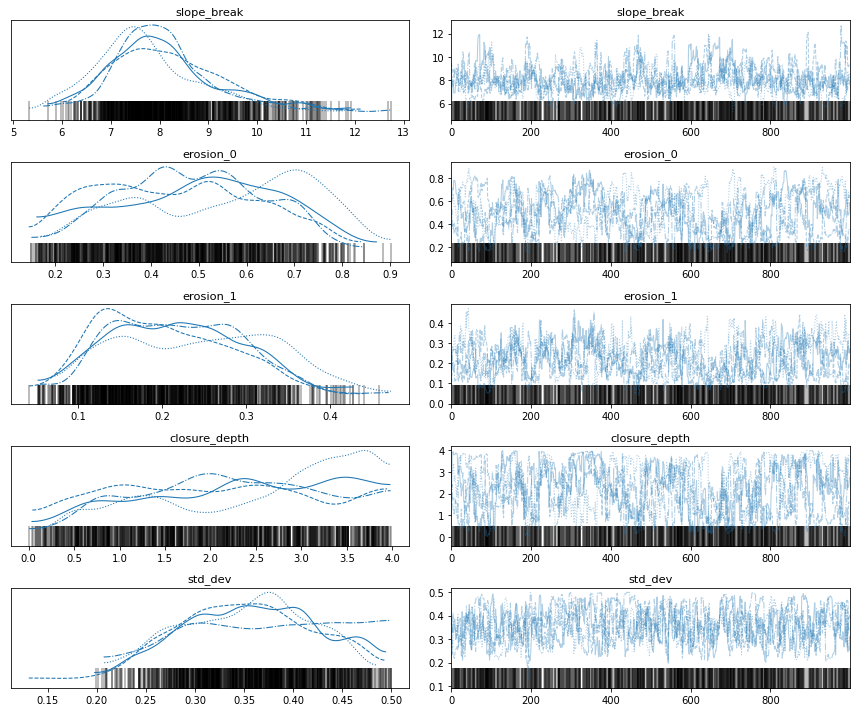

In [17]:
az.plot_trace(trace);
plt.tight_layout();